# **Set up the environment and import the data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#import the csv file
df = pd.read_csv('ds_salaries.csv')

#show the first 10 columns of the data
df.head(5)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [ ]:
#show the detailed information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [ ]:
#process the data
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)

,id,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,working years
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,3
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,3
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,3
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,3
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,3


# Average Salary by Job Title

In [ ]:
from pyspark.sql.functions import desc
from pyspark.sql import SparkSession

#create a sparksession
spark = SparkSession.builder.appName("JobTitleCount").getOrCreate()
spark_df = spark.createDataFrame(df)

#find the top 5 job title in the data and the average salary
job_title = spark_df.groupby('job_title')\
        .agg({'id':'count', 'salary_in_usd':'avg'})\
        .orderBy(desc('count(id)'))
job_title = job_title.withColumnRenamed('count(id)', 'count')
job_title = job_title.withColumnRenamed('avg(salary_in_usd)', 'avg_salary')
job_title = job_title.limit(5)
job_title.show()

+--------------------+-----+------------------+
|           job_title|count|        avg_salary|
+--------------------+-----+------------------+
|      Data Scientist|  143|108187.83216783217|
|       Data Engineer|  132|          112725.0|
|        Data Analyst|   97| 92893.06185567011|
|Machine Learning ...|   41|104880.14634146342|
|  Research Scientist|   16|          109019.5|
+--------------------+-----+------------------+



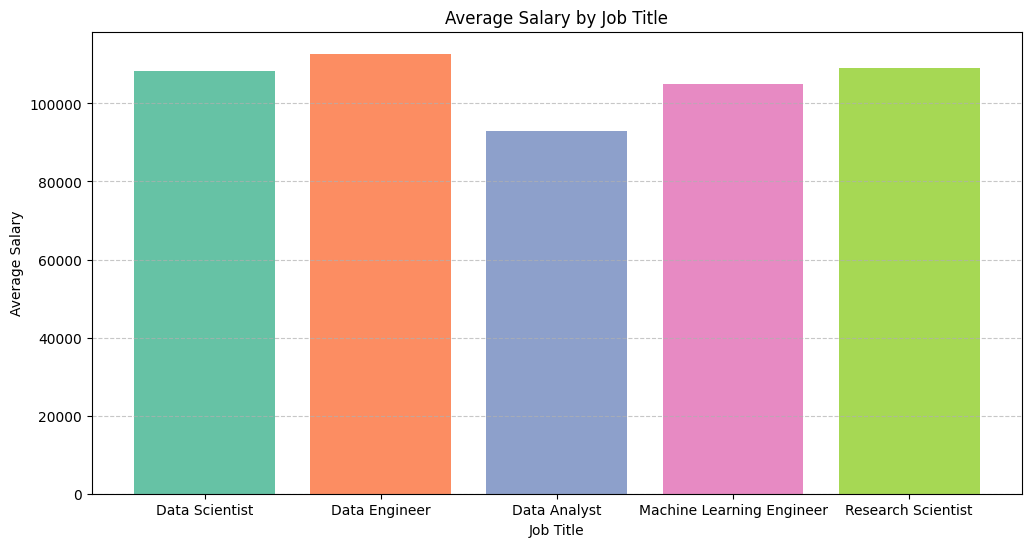

In [ ]:
#plot the graph of the average salary by the top5 job title
import seaborn as sns
plt.figure(figsize=(12, 6))
colors = sns.color_palette('Set2', 5)
plt.bar(job_title.select('job_title').toPandas()['job_title'], job_title.select('avg_salary').toPandas()['avg_salary'], color = colors)
plt.xlabel('Job Title')
plt.ylabel('Average Salary')
plt.title('Average Salary by Job Title')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average Salary by Remote Ratio

In [ ]:
#find the average salary according to the remote ratio
remote_ratio = spark_df.groupby('remote_ratio')\
        .agg({'id':'count', 'salary_in_usd':'avg'})\
        .orderBy(desc('remote_ratio'))
remote_ratio = remote_ratio.withColumnRenamed('count(id)', 'count')
remote_ratio = remote_ratio.withColumnRenamed('avg(salary_in_usd)', 'avg_salary')
remote_ratio.show()

+------------+-----+------------------+
|remote_ratio|count|        avg_salary|
+------------+-----+------------------+
|         100|  381|122457.45406824147|
|          50|   99|  80823.0303030303|
|           0|  127|106354.62204724409|
+------------+-----+------------------+



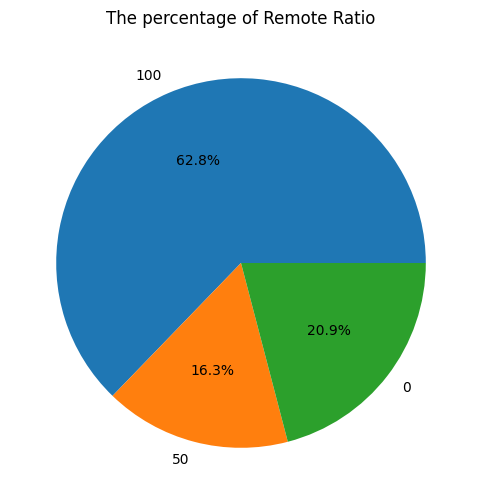

In [ ]:
plt.figure(figsize=(12, 6))
plt.pie(remote_ratio.select('count').toPandas()['count'], labels=remote_ratio.select('remote_ratio').toPandas()['remote_ratio'], autopct='%1.1f%%')
plt.title('The percentage of Remote Ratio')
plt.show()

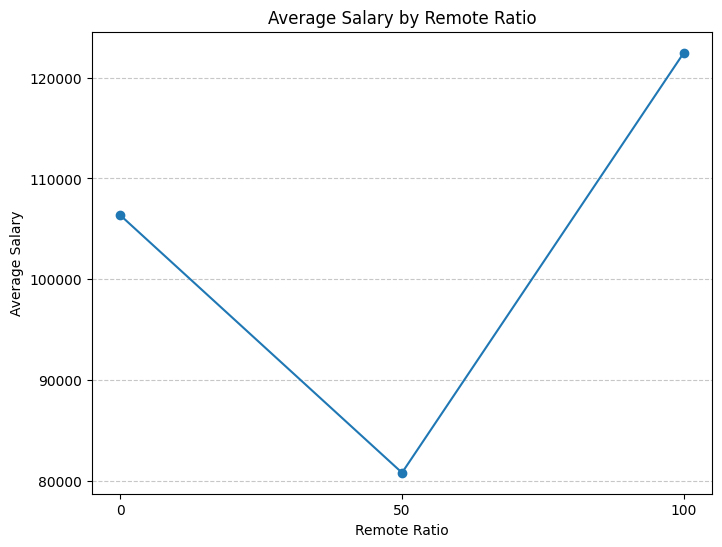

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(remote_ratio.select('remote_ratio').toPandas()['remote_ratio'], remote_ratio.select('avg_salary').toPandas()['avg_salary'], marker='o')
remote_ratios = remote_ratio.select('remote_ratio').toPandas()['remote_ratio'].tolist()
plt.xticks(remote_ratios, remote_ratios)
plt.xlabel('Remote Ratio')
plt.ylabel('Average Salary')
plt.title('Average Salary by Remote Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average Salary by Work Year

In [ ]:
work_year = spark_df.groupby('work_year')\
        .agg({'id':'count', 'salary_in_usd':'avg'})\
        .orderBy(desc('work_year'))
work_year = work_year.withColumnRenamed('count(id)', 'count')
work_year = work_year.withColumnRenamed('avg(salary_in_usd)', 'avg_salary')
work_year.show()

+---------+-----+------------------+
|work_year|count|        avg_salary|
+---------+-----+------------------+
|     2022|  318|124522.00628930818|
|     2021|  217| 99853.79262672811|
|     2020|   72|           95813.0|
+---------+-----+------------------+



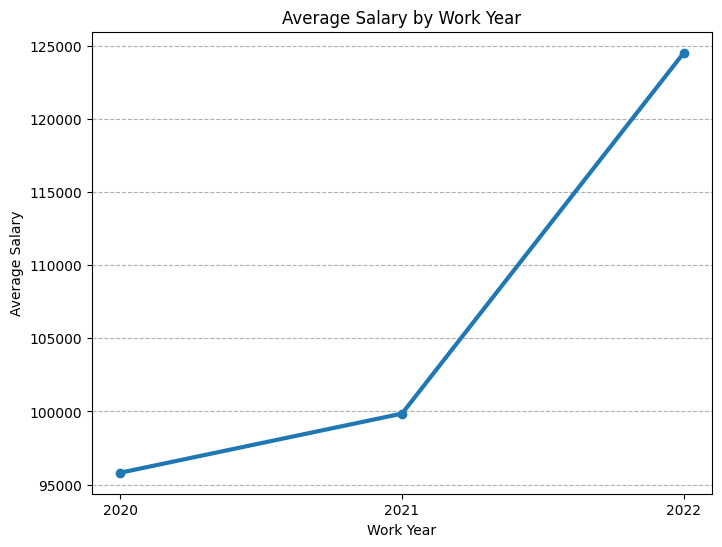

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(work_year.select('work_year').toPandas()['work_year'], work_year.select('avg_salary').toPandas()['avg_salary'], linewidth=3, marker='o')
work_years = work_year.select('work_year').toPandas()['work_year'].tolist()
plt.xticks(work_years, work_years)
plt.xlabel('Work Year')
plt.ylabel('Average Salary')
plt.title('Average Salary by Work Year')
plt.grid(axis='y', linestyle='--')
plt.show()

# Average Salary by Employee Residence

In [ ]:
employee_residence = spark_df.groupby('employee_residence')\
        .agg({'id':'count', 'salary_in_usd':'avg'})\
        .orderBy(desc('count(id)'))
employee_residence = employee_residence.withColumnRenamed('count(id)', 'count')
employee_residence = employee_residence.withColumnRenamed('avg(salary_in_usd)', 'avg_salary')
#find the top 5 residence
employee_residence = employee_residence.limit(5)
employee_residence.show()

+------------------+-----+------------------+
|employee_residence|count|        avg_salary|
+------------------+-----+------------------+
|                US|  332| 149194.1174698795|
|                GB|   44| 81403.15909090909|
|                IN|   30|37322.333333333336|
|                CA|   29| 97085.31034482758|
|                DE|   25|          85552.56|
+------------------+-----+------------------+



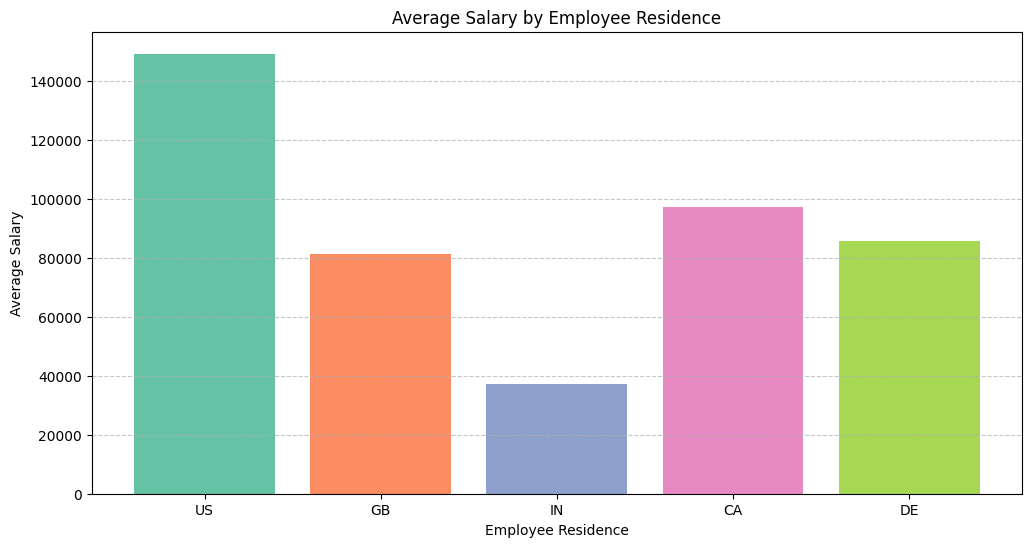

In [ ]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette('Set2', 5)
plt.bar(employee_residence.select('employee_residence').toPandas()['employee_residence'], employee_residence.select('avg_salary').toPandas()['avg_salary'], color = colors)
plt.xlabel('Employee Residence')
plt.ylabel('Average Salary')
plt.title('Average Salary by Employee Residence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average Salary by Company Size

In [ ]:
company_size = spark_df.groupby('company_size')\
        .agg({'salary_in_usd':'avg'})\
        .orderBy(desc('company_size'))

company_size = company_size.withColumnRenamed('avg(salary_in_usd)', 'avg_salary')
company_size.show()

+------------+------------------+
|company_size|        avg_salary|
+------------+------------------+
|           S| 77632.67469879518|
|           M|116905.46625766871|
|           L|119242.99494949495|
+------------+------------------+



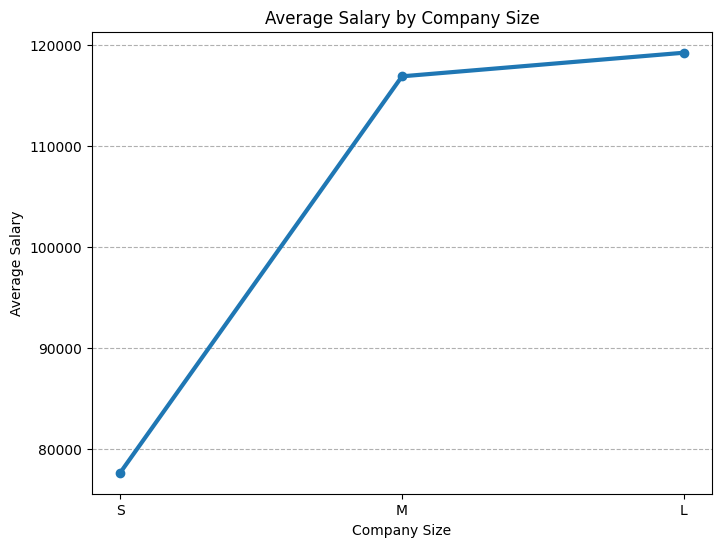

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(company_size.select('company_size').toPandas()['company_size'], company_size.select('avg_salary').toPandas()['avg_salary'], linewidth=3, marker='o')
company_sizes = company_size.select('company_size').toPandas()['company_size'].tolist()
plt.xticks(company_sizes, company_sizes)
plt.xlabel('Company Size')
plt.ylabel('Average Salary')
plt.title('Average Salary by Company Size')
plt.grid(axis='y', linestyle='--')
plt.show()

# Decision Tree Regression

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score


X = df[['work_year', 'experience_level', 'job_title', 'employee_residence', 'remote_ratio', 'company_size']]
y = df['salary_in_usd']

#use one hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['experience_level', 'job_title', 'employee_residence', 'company_size']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['experience_level', 'job_title', 'employee_residence', 'company_size']))

X_encoded = pd.concat([X[['work_year', 'remote_ratio']], encoded_df], axis=1)


#split the data
Xtr, Xts, ytr, yts = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

regr = DecisionTreeRegressor(max_depth=6)
regr.fit(Xtr, ytr)

#predict the salary
y_pred = regr.predict(Xts)

#calculate the mean squared error and r-squared
mse = mean_squared_error(yts, y_pred)
r2 = r2_score(yts, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1918173692.9132948
R-squared: 0.4995070918392286
